In [10]:
from pathlib import Path
import pickle
from rich import print
import numpy as np

stats_path = Path("stats")

def read_stats(path):
    databytes = path.read_bytes()
    stats = pickle.loads(databytes)
    return stats

stats_data = {}
diario = {}

for stats in stats_path.glob("*.pydat"):
    data = read_stats(stats)
    for name, items in data.items():
        remover = []
        for i,item in enumerate(items):
            if item["analisis"] == "date":
                nombre  = item["nombre"]
                if nombre not in diario:
                    diario[nombre] = []
                diario[nombre].append(item)
                remover.append(item)
        for r in remover:            
            items.remove(r)
        stats_data.update(data)


Haremos un análisis de regresión predictiva para las curvas de media diaria.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [8]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


Esto se puede realizar análisis sobre una estación y tipo

In [11]:
one_station =pd.DataFrame(diario["LAVEGA"])

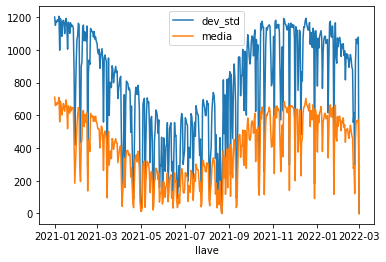

In [44]:

one_station[one_station["tipo"]==1].plot(x="llave",y=["dev_std","media"])
plt.savefig("serie-time-lavega-tipo1.png")

<AxesSubplot:xlabel='llave'>

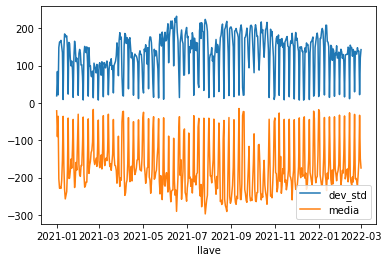

In [14]:
one_station[one_station["tipo"]==3].plot(x="llave",y=["dev_std","media"])

In [15]:
one_station[one_station["tipo"]==4].plot(x="llave",y=["dev_std","media"])

<AxesSubplot:xlabel='llave'>

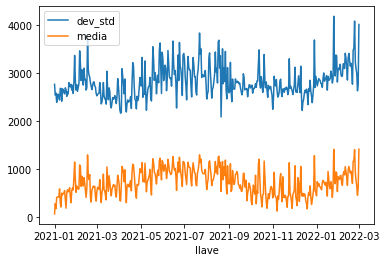

In [43]:
one_station[one_station["tipo"]==6].plot(x="llave",y=["dev_std","media"])
plt.savefig("serie-time-lavega-tipo6.png")


Enfocamos el estudio en los flujos de tipo 1 y 6, que presentan periodicidad por temporada. así como semanal.

- 1 : proviene de generación
- 6 : flujo de transmisión

Asimismo, aquellas barras que destaque '5:Consumo Regulado' se puede seleccionar.

In [19]:
station_flujo_1 = one_station[one_station["tipo"]==1]
station_flujo_6 = one_station[one_station["tipo"]==6]
                              

In [27]:
fraccion = .30
index_1 = int(fraccion * len(station_flujo_1.index))
index_6 = int(fraccion * len(station_flujo_6.index))

In [21]:
print(index_1, index_6)

297 297

In [22]:
station_flujo_1.head()

nombre  tipo analisis       llave       media      dev_std  median
0  LAVEGA     1     date  2021-01-01  710.468620  1200.164228     0.0
1  LAVEGA     1     date  2021-01-02  659.047885  1149.318320     0.0
2  LAVEGA     1     date  2021-01-03  674.827344  1175.178921     0.0
3  LAVEGA     1     date  2021-01-04  663.979120  1169.528234     0.0
4  LAVEGA     1     date  2021-01-05  678.760146  1182.496095     0.0

In [28]:
data_train = station_flujo_1[:-index_1]
data_test = station_flujo_1[-index_1:]


print(f"Entrenamiento {data_train.llave.min()} {data_train.llave.max()} n: {len(data_train)}") 
print(f"Test {data_test.llave.min()} {data_test.llave.max()} n: {len(data_test)}") 

Entrenamiento 2021-01-01 2021-10-25 n: 298

Test 2021-10-26 2022-03-01 n: 127

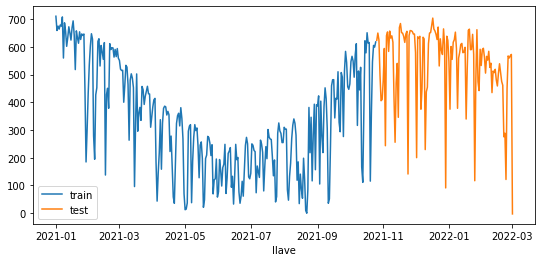

In [32]:
fix, ax = plt.subplots(figsize=(9,4))
data_train.plot(x="llave",y="media",ax=ax, label="train")
data_test.plot(x="llave",y="media",ax=ax, label="test")
ax.legend()

Creación del modelo de predicción por forecasting

In [36]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=200),
    lags = 28
    )

In [42]:
forecaster.fit(x=data_train["llave"],y=data_train["media"])
forecaster

TypeError: fit() got an unexpected keyword argument 'x'

In [40]:
steps = 6 * 28
predictions = forecaster.predict(steps=steps)
predictions.head(5)

298    554.552526
299    472.318972
300    461.261029
301    450.142103
302    391.378600
Name: pred, dtype: float64

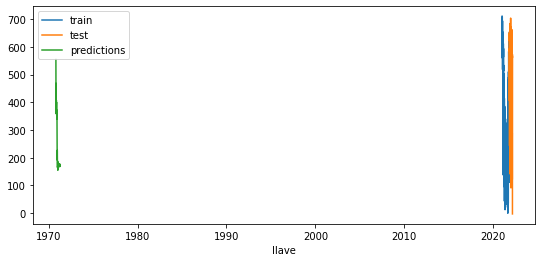

In [41]:
fix, ax = plt.subplots(figsize=(9,4))
data_train.plot(x="llave",y="media",ax=ax, label="train")
data_test.plot(x="llave",y="media",ax=ax, label="test")
predictions.plot(ax=ax, label="predictions")
ax.legend()